<a href="https://colab.research.google.com/github/henryHyun/KNU/blob/main/RBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

-4.538907878688658
-1.218824341861424
0.85719712507496
1.762938900034565
2.3119654868965718
2.6086630750058304
2.7589078142698895
2.847526973244478
2.9512514061510946
2.999308978570804


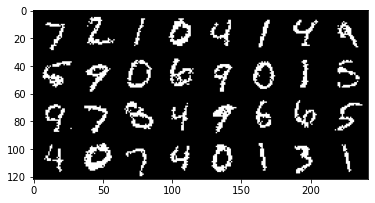

In [ ]:
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid
 
 
#%% 시각화를 위해 필요한 함수
 
# get_ipython().run_line_magic('matplotlib', 'inline') # inline 출력 필요한 경우 주석 처리 제거할 것.
import matplotlib.pyplot as plt
 
def show_adn_save(file_name,img):               # 이미지를 바꿔도 출력 가능? 
    npimg = np.transpose(img.numpy(),(1,2,0))
    f = "./%s.png" % file_name
    plt.imshow(npimg)
    plt.imsave(f, npimg)
 
 
#%% RBM 모듈 만들기
class RBM(nn.Module):
    def __init__(self,
                 n_vis=784,
                 n_hin=500,
                 k=5):
        super(RBM, self).__init__()
        # 여타 initialization에 비해 이와 같은 방식이 학습이 제일 잘 됨.
        self.W = nn.Parameter(torch.randn(n_hin,n_vis)*1e-2) 
        self.v_bias = nn.Parameter(torch.zeros(n_vis)) # bias는 0으로 초기화.
        self.h_bias = nn.Parameter(torch.zeros(n_hin)) # bias는 0으로 초기화.
        
        self.k = k # Contrastive Divergence의 횟수
    
    def sample_from_p(self,p):
        # Gibbs Sampling 과정
        # 확률 계산 후 uniform distribution으로부터 얻은 값 보다 크면 1, 아니면 -1로 출력하고
        # relu 함수를 이용해 -1로 출력된 값들은 모두 0으로 처리해버림.
        p_ = p - Variable(torch.rand(p.size()))
        p_sign = torch.sign(p_)
        return F.relu(p_sign)
    
    def v_to_h(self,v):
        # 주어진 visible units로부터 hidden unit을 sampling하는 과정
        p_h = torch.sigmoid(F.linear(v,self.W,self.h_bias))
        sample_h = self.sample_from_p(p_h)
        return p_h,sample_h
    
    def h_to_v(self,h):
        # hidden unit의 샘플로부터 visible unit을 다시 복원해보는 과정
        p_v = torch.sigmoid(F.linear(h,self.W.t(),self.v_bias))
        sample_v = self.sample_from_p(p_v)
        return p_v,sample_v
        
    def forward(self,v):
        # RBM에서 forward propagation은 visible -> hidden -> 다시 visible로 
        # hidden unit과 visible unit을 샘플링 하는 과정을 말함.
        pre_h1,h1 = self.v_to_h(v)
        
        h_ = h1
        for _ in range(self.k): # Contrastive Divergence를 k 번 수행함.
            pre_v_,v_ = self.h_to_v(h_)
            pre_h_,h_ = self.v_to_h(v_)
        
        # 아래의 v는 입력으로 들어온 v이고 v_는 sampling으로 얻은 h로부터 다시 획득한 입력 샘플
        return v,v_
    
    def free_energy(self,v):
        # Free Energy 계산
        vbias_term = v.mv(self.v_bias) # mv: matrix - vector product
        wx_b = F.linear(v,self.W,self.h_bias)
        
        temp = torch.log(
            torch.exp(wx_b) + 1
            )
        hidden_term = torch.sum(temp, dim = 1)
        
        return (-hidden_term - vbias_term).mean()
 
 
#%% 데이터 셋 불러오기: MNIST 이용                                # 손으로 쓴 숫자를 모델링 한것 같다. 숫자를 읽고 숫자를 출력. 
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./MNIST_data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size)
 
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./MNIST_data', train=False, transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size)
 
 
#%% RBM 모델 객체 및 최적화 함수 객체 만들기     # 수업시간에 했던거. optimizing process 
 
rbm = RBM(k=1) # CD의 k = 1로 설정. 
# 즉, visible unit을 딱 한번만 sampling 해주고 
# 그걸로 원래의 visible unit의 데이터와 configuration 비교해서 loss로 삼겠다는 의미.
train_op = optim.Adam(rbm.parameters(), 0.005) # 어떤 Optimizer를 넣어줘도 무관함.
 
#%% RBM 학습
 
for epoch in range(10):
    loss_ = []
    for _, (data,target) in enumerate(train_loader): # Stochastic Gradient Descent 수행함. # 경사하강법.....? 이거 이해안감  
        data = Variable(data.view(-1,784))
        sample_data = data.bernoulli() # RBM의 입력은 0 또는 1의 값만 가져야 함.
        
        v,v1 = rbm(sample_data)
        loss = rbm.free_energy(v) - rbm.free_energy(v1)
        loss_.append(loss.data.item())
        train_op.zero_grad()
        loss.backward() # RBM의 Backpropagation은 원래의 입력과 sampling 된 입력간의 차이를 줄여주는 과정 차이를 줄이면 오차가 줄어든다. 
        train_op.step()
    
    print(np.mean(loss_))
 
#%% Test Data로부터 원본 데이터와 샘플링된 입력 데이터를 비교해보자.    # 맨 위의 Q처럼, test data를 내가 입력할 수 있다면? 
 
testset = datasets.MNIST('./MNIST_data', train=False, transform=transforms.Compose([
                       transforms.ToTensor()
                   ]))
 
sample_data = testset.data[:32,:].view(-1, 784) # 총 32개 데이터를 받아옴. # 숫자가 32개. 하나씩 새어봤음. 
sample_data = sample_data.type(torch.FloatTensor)/255.
 
v, v1 = rbm(sample_data) # v 와 v1 이 샘플 데이터에 저장된다. 
show_adn_save("real_testdata",make_grid(v.view(32,1,28,28).data)) # 테스트 데이터 입력 
show_adn_save("generated_testdata",make_grid(v1.view(32,1,28,28).data))  # 모델링된 데이터 출력 

# 꼭 숫자? 
# 파이썬에는 UTF-8코드가 심어져 있는데 이걸 기반으로 내가 손으로 영어 글씨를 쓰고 RBM에 입력하면 알아 들을까? 
# 데이터 크기 확장 가능? 32개의 숫자 말고, 홈페이지 전체 해석이나 번역 가능? 
# 경사하강법 시각화 가능? 
# 물리문제와 연계한다면 어떤 문제를? 